# DataJoint Element for Motion Sequencing with Keypoint-MoSeq


#### **Open-source Data Pipeline for Motion Sequencing in Neurophysiology**


Welcome to the tutorial for the DataJoint Element for motion sequencing analysis. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline by `element-moseq`.


![pipeline](../images/flowchart.svg)


The package is designed to seamlessly integrate the **PCA fitting**, **model fitting** through **initialization**, **fitting an AR-HMM**, and **fitting the full keypoint-SLDS model** into a data pipeline and streamline model and video management using DataJoint.


![pipeline](../images/pipeline.svg)


By the end of this tutorial, you will have a clear grasp of how to set up and integrate the `Element MoSeq` into your specific research projects and your lab.


### Prerequisites

Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) proceeding.
A basic understanding of the following DataJoint concepts will be beneficial to your understanding of this tutorial:

1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method.


#### **Tutorial Overview**


- Setup
- _Activate_ the DataJoint pipeline
- _Insert_ example data into subject and session tables
- _Insert_ the keypoint data from the pose estimation and the body parts in the DataJoint pipeline
- _Fit a PCA model_ to aligned and centered keypoint coordinates and _select_ the latent dimension
- _Train the AR-HMM and Keypoint-SLDS Models_
- _Run the inference_ task and _visualize_ the results


### **Setup**


This tutorial loads the keypoint data extracted by DeepLabCut of a single freely moving mouse in an open-field environment. The goal is to link this point tracking to pose dynamics by identifying its behavioral modules ("syllables") without human supervision. The modeling results are stored as a `.h5` file and a subdirectory of `.csv` files that contain the following information:

- Behavior modules as "syllables": the syllable label assigned to each frame (i.e. the state indexes assigned by the model)
- Centroid and heading in each frame, as estimated by the model, that capture the animal's overall position in allocentric coordinates
- Latent state: low-dimensional representation of the animal's pose in each frame. These are similar to PCA scores, and are modified to reflect the pose dynamics and noise estimates inferred by the model.

The results of this Element example can be combined with **other modalities** to create a complete customizable data pipeline for your specific lab or study. For instance, you can combine `element-moseq` with `element-deeplabcut` and `element-calcium-imaging` to characterize the neural activity along with natural sub-second rhythmicity in mouse movement.

#### Steps to Run the Element-MoSeq

The input data for this data pipeline is as follows:

- A DeepLabCut (DLC) project folder with its configuration file as `.yaml` file, video set as `.mp4`, and keypoint tracking as `.h5` files.
- Selection of the anterior, posterior, and use bodyparts for the model fitting.

This tutorial includes the keypoints example data in `example_data/inbox/dlc_project`.


Let's start this tutorial by importing the packages necessary to run the data pipeline.


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
from pathlib import Path
import numpy as np
import glob

from element_moseq.moseq_infer import (
    get_kpms_root_data_dir,
    get_kpms_processed_data_dir,
)
from element_interface.utils import find_full_path

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results.

Let's connect to the database server.


In [ ]:
dj.conn()

### **Activate the DataJoint pipeline**


This tutorial presumes that the `element-moseq` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. Please refer to the `tutorial_pipeline.py` for the source code.

Now, we will proceed to import the essential schemas required to construct this data pipeline, with particular attention to the primary components: `moseq_train` and `moseq_infer`.


In [5]:
from tutorial_pipeline import lab, subject, session, moseq_train, moseq_infer

[2024-03-25 18:23:27,646][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `moseq_train` and `moseq_infer` schemas as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


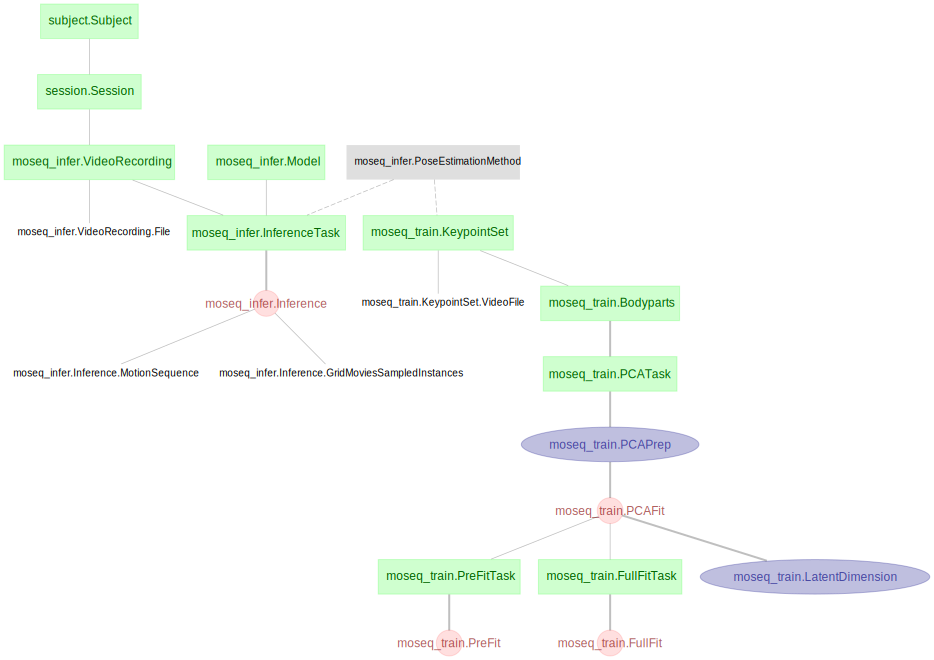

In [6]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(moseq_train)
    + dj.Diagram(moseq_infer)
)

As evident from the diagram, this data pipeline encompasses several tables associated with different keypoint-MoSeq components like pca, pre-fitting of AR-HMM, and full fitting of the model. A few tables, such as `subject.Subject` or `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-moseq` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `moseq_train` and `moseq_infer` schemas.


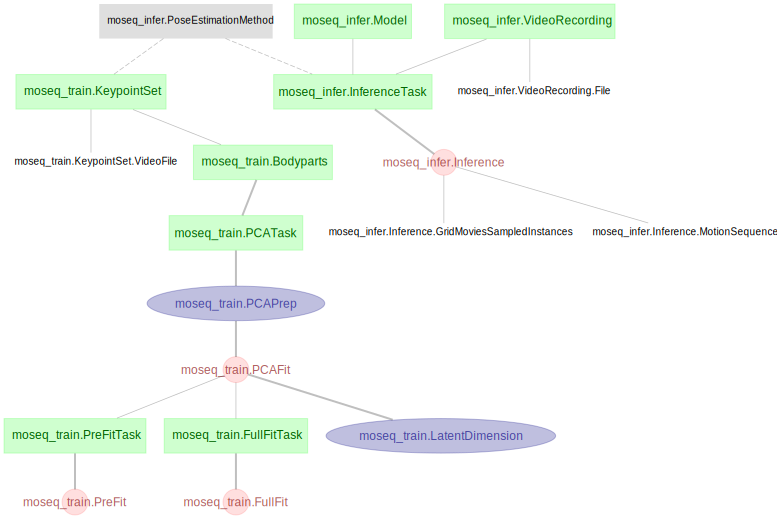

In [7]:
(dj.Diagram(moseq_train) + dj.Diagram(moseq_infer))

### **Insert example data into subject and session tables**


Let's delve into the `subject.Subject` and `session.Session` tables and include some example data.


In [8]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,F,2024-01-01,test subject


Add a new entry for a subject in the `Subject` table:


In [9]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2024-01-01",
        subject_description="test subject",
    ),
    skip_duplicates=True,
)

Create session keys and input them into the `Session` table:


In [10]:
# Definition of the dictionary named "session_keys"
session_keys = [
    dict(subject="subject1", session_datetime="2024-03-15 14:04:22"),
    dict(subject="subject1", session_datetime="2024-03-16 14:43:10"),
]

# Insert this dictionary in the Session table
session.Session.insert(session_keys, skip_duplicates=True)

Confirm the inserted data:


In [11]:
session.Session()

subject,session_datetime
subject1,2024-03-15 14:04:22
subject1,2024-03-16 14:43:10


Let's define a `key` to use throughout the notebook:


In [12]:
key = session_keys[0]
key

{'subject': 'subject1', 'session_datetime': '2024-03-15 14:04:22'}

### **Insert the keypoint data from the pose estimation and the body parts in the DataJoint pipeline**


The `PoseEstimationMethod` table contains the pose estimation methods and file formats supported by the keypoint loader of `keypoint-moseq` package. In this tutorial, the keypoint input data are `.h5` files that have been obtained using `DeepLabCut`.


In [13]:
moseq_infer.PoseEstimationMethod()

"pose_estimation_method Supported pose estimation method (deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap)",pose_estimation_desc Optional. Pose estimation method description with the supported formats.
anipose,`.csv` files generated by anipose analysis
deeplabcut,`.csv` and `.h5/.hdf5` files generated by DeepLabcut analysis
facemap,`.h5` files generated by Facemap analysis
nwb,`.nwb` files with Neurodata Without Borders (NWB) format
sleap,`.slp` and `.h5/.hdf5` files generated by SLEAP analysis
sleap-anipose,`.h5/.hdf5` files generated by sleap-anipose analysis


Insert keypoint input metadata into the `KeypointSet` table:


In [14]:
moseq_train.KeypointSet.insert1(
    {
        "kpset_id": 1,
        "pose_estimation_method": "deeplabcut",
        "kpset_dir": "dlc_project",
        "kpset_desc": "Example keypoint set",
    },
    skip_duplicates=True,
)

In [15]:
moseq_train.KeypointSet()

kpset_id Unique ID for each keypoint set,"pose_estimation_method Supported pose estimation method (deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap)","kpset_dir Path where the keypoint files are located together with the pose estimation `config` file, relative to root data directory",kpset_desc Optional. User-entered description
1,deeplabcut,dlc_project,Example keypoint set


Add the video files in `KeypointSet.VideoFile` that will be used to fit the model:


In [16]:
videos_path = [
    "dlc_project/videos/21_12_10_def6a_3.top.ir.mp4",
    "dlc_project/videos/22_04_26_cage4_1_1.top.ir.mp4",
    "dlc_project/videos/21_12_10_def6a_1_1.top.ir.mp4",
    "dlc_project/videos/22_27_04_cage4_mouse2_0.top.ir.mp4",
    "dlc_project/videos/22_04_26_cage4_0.top.ir.mp4",
    "dlc_project/videos/21_11_8_one_mouse.top.ir.Mp4",
    "dlc_project/videos/21_12_2_def6b_2.top.ir.mp4",
    "dlc_project/videos/21_12_10_def6b_3.top.ir.Mp4",
    "dlc_project/videos/22_04_26_cage4_0_2.top.ir.mp4",
    "dlc_project/videos/21_12_2_def6a_1.top.ir.mp4",
]

# Insert the video files in the `VideoFile` table
moseq_train.KeypointSet.VideoFile.insert(
    (
        {"kpset_id": 1, "video_id": v_idx, "video_path": f}
        for v_idx, f in enumerate(videos_path)
    ),
    skip_duplicates=True,
)
moseq_train.KeypointSet.VideoFile()

kpset_id Unique ID for each keypoint set,"video_id Unique ID for each video corresponding to each keypoint data file, relative to root data directory","video_path Filepath of each video from which the keypoints are derived, relative to root data directory"
1,0,dlc_project/videos/21_12_10_def6a_3.top.ir.mp4
1,1,dlc_project/videos/22_04_26_cage4_1_1.top.ir.mp4
1,2,dlc_project/videos/21_12_10_def6a_1_1.top.ir.mp4
1,3,dlc_project/videos/22_27_04_cage4_mouse2_0.top.ir.mp4
1,4,dlc_project/videos/22_04_26_cage4_0.top.ir.mp4
1,5,dlc_project/videos/21_11_8_one_mouse.top.ir.Mp4
1,6,dlc_project/videos/21_12_2_def6b_2.top.ir.mp4
1,7,dlc_project/videos/21_12_10_def6b_3.top.ir.Mp4
1,8,dlc_project/videos/22_04_26_cage4_0_2.top.ir.mp4
1,9,dlc_project/videos/21_12_2_def6a_1.top.ir.mp4


Now, let's insert the body parts to use in the analysis:


In [17]:
pca_task_key = {"kpset_id": 1, "bodyparts_id": 1}
moseq_train.Bodyparts.insert1(
    {
        **pca_task_key,
        "anterior_bodyparts": ["nose"],
        "posterior_bodyparts": ["spine4"],
        "use_bodyparts": [
            "spine4",
            "spine3",
            "spine2",
            "spine1",
            "head",
            "nose",
            "right ear",
            "left ear",
        ],
    },
    skip_duplicates=True,
)

In [18]:
moseq_train.Bodyparts()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,anterior_bodyparts List of strings of anterior bodyparts,posterior_bodyparts List of strings of posterior bodyparts,use_bodyparts List of strings of bodyparts to be used,bodyparts_desc Optional. User-entered description
1,1,=BLOB=,=BLOB=,=BLOB=,


### **Fit a PCA model to aligned and centered keypoint coordinates and select the latent dimension**


To conduct model fitting for keypoint-MoSeq, both a PCA model and the latent dimension of the pose trajectory are necessary.


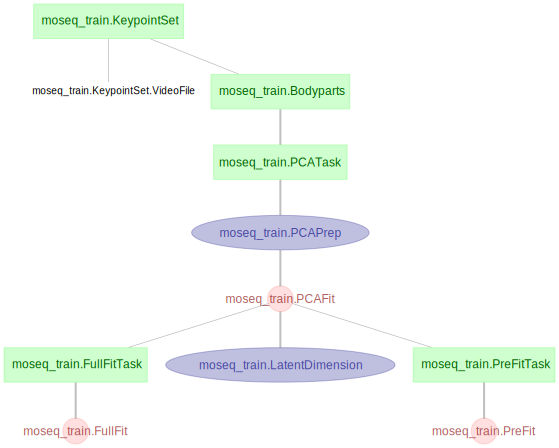

In [19]:
dj.Diagram(moseq_train)

The `PCATask` table serves the purpose of specifying the PCA task.


In [20]:
moseq_train.PCATask()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,"kpms_project_output_dir Keypoint-MoSeq project output directory, relative to root data directory"
1,1,kpms_project_tutorial


Defining and inserting a PCA task requires:

1. Select a keypoint set
2. Select the body parts to use
3. Specify the output directory for the KPMS project


In [21]:
moseq_train.PCATask.insert1(
    {
        **pca_task_key,
        "kpms_project_output_dir": "kpms_project_tutorial",
    },
    skip_duplicates=True,
)

In [22]:
moseq_train.PCATask()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,"kpms_project_output_dir Keypoint-MoSeq project output directory, relative to root data directory"
1,1,kpms_project_tutorial


Before running the PCA fitting, the keypoint detections and body parts need to be formatted. The resulting coordinates and confidences scores will be used to format the data for modeling.


In [23]:
moseq_train.PCAPrep()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,"coordinates Dictionary mapping filenames to keypoint coordinates as ndarrays of shape (n_frames, n_bodyparts, 2[or 3])","confidences Dictionary mapping filenames to `likelihood` scores as ndarrays of shape (n_frames, n_bodyparts)",formatted_bodyparts List of bodypart names. The order of the names matches the order of the bodyparts in `coordinates` and `confidences`.,average_frame_rate Average frame rate of the videos for model training,frame_rates List of the frame rates of the videos for model training
1,1,=BLOB=,=BLOB=,=BLOB=,30.0,=BLOB=


Populate the `PCAPrep` table will:

1. Create the output directory, if it does not exist, with the kpms default `config.yml` file that contains the default values from the pose estimation
2. Generate a copy as `dj_config.yml` and update it with both the video directory and the bodyparts
3. Create and store the keypoint coordinates and confidences scores to format the data for the PCA fitting
4. Calculate the average frame rate of the videoset chosen to train the model. This will be useful to calculate the kappa value in the next step.


In [24]:
moseq_train.PCAPrep.populate()

In [25]:
moseq_train.PCAPrep()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,"coordinates Dictionary mapping filenames to keypoint coordinates as ndarrays of shape (n_frames, n_bodyparts, 2[or 3])","confidences Dictionary mapping filenames to `likelihood` scores as ndarrays of shape (n_frames, n_bodyparts)",formatted_bodyparts List of bodypart names. The order of the names matches the order of the bodyparts in `coordinates` and `confidences`.,average_frame_rate Average frame rate of the videos for model training,frame_rates List of the frame rates of the videos for model training
1,1,=BLOB=,=BLOB=,=BLOB=,30.0,=BLOB=


The `PCAFit` computation will format the aligned and centered keypoint coordinates, fit a PCA model, and save it as `pca.p` file in the output directory.


In [26]:
moseq_train.PCAFit.populate()

In [27]:
moseq_train.PCAFit()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,pca_fit_time datetime of the PCA fitting analysis
1,1,2024-03-25 17:23:44


However, we still need to determine the specific dimension of the pose trajectory to utilize for fitting the keypoint-MoSeq model. A helpful guideline is to consider the number of dimensions required to explain 90% of the variance, or a maximum of 10 dimensions, whichever is lower.

The computation of `LatentDimension` will automatically identify the components that explain 90% of the variance, aiding the user in making the final decision regarding an appropriate latent dimension for model fitting.


In [28]:
moseq_train.LatentDimension.populate()

In [29]:
moseq_train.LatentDimension()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,variance_percentage Variance threshold. Fixed value to 90 percent.,latent_dimension Number of principal components required to explain the specified variance.,latent_dim_desc Automated description of the computation result.
1,1,90.0,4,>=90.0% of variance explained by 4 components.


To aid the user in selecting the latent dimensions for model fitting, two plots are created below: a cumulative scree plot and a visualization of each Principal Component (PC). In this visualization, translucent nodes/edges represent the mean pose, while opaque nodes/edges represent a perturbation in the direction of the PC.
The plots are stored in the output directory.


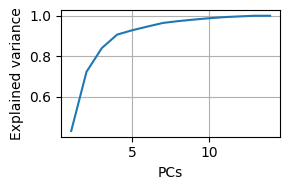

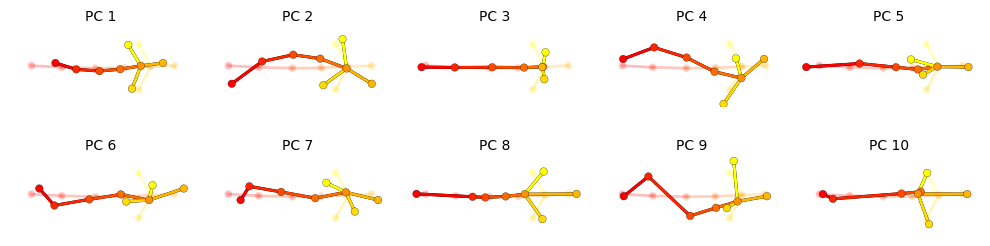

In [30]:
# Generate and store plots for the user to choose the latent dimensions in the next step
from keypoint_moseq import load_pca, plot_scree, plot_pcs
from element_moseq.readers.kpms_reader import load_kpms_dj_config

kpms_project_output_dir = (moseq_train.PCATask & pca_task_key).fetch1(
    "kpms_project_output_dir"
)
kpms_project_output_dir = get_kpms_processed_data_dir() / kpms_project_output_dir

kpms_dj_config = load_kpms_dj_config(
    kpms_project_output_dir.as_posix(), check_if_valid=False, build_indexes=False
)
pca = load_pca(kpms_project_output_dir.as_posix())

plot_scree(pca, project_dir=kpms_project_output_dir.as_posix())
plot_pcs(pca, project_dir=kpms_project_output_dir.as_posix(), **kpms_dj_config)

The chosen dimension for the next steps in the analysis will be `latent dimension = 4`.


### **Train the AR-HMM and keypoint-SLDS Models**


The pre-fitting and full-fitting processes for the KPMS Model involve the following steps:

1. **Initialization**: Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA
2. **Fitting an AR-HMM**: AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling
3. **Fitting the full model**: All parameters, including both AR-HMM and centroid, heading, noise-estimates, and continuous latent states (i.e., pose trajectories) are iteratively updated through Gibbs sampling. This step is particularly useful for noisy data.


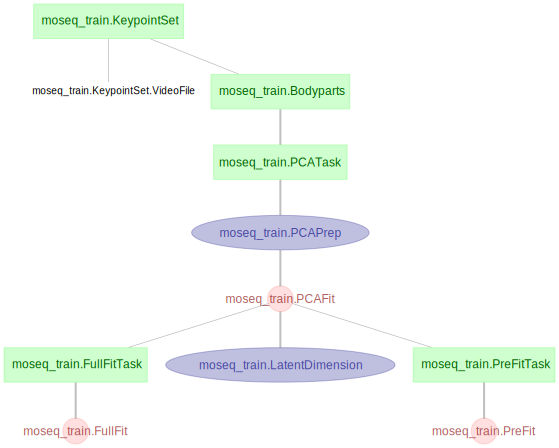

In [31]:
dj.Diagram(moseq_train)

For the pre-fitting step (fitting an AR-HMM), a pre-fitting task needs to be defined and inserted:


In [32]:
moseq_train.PreFitTask()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,pre_latent_dim Latent dimension to use for the model pre-fitting,pre_kappa Kappa value to use for the model pre-fitting,pre_num_iterations Number of Gibbs sampling iterations to run in the model pre-fitting,pre_fit_desc User-defined description of the pre-fitting task


This task requires the following inputs:

1. The keypoint set, body parts, and latent dimension (extracted in the section above).
2. A kappa value for the model pre-fitting.
3. The number of iterations for the model pre-fitting.


**Kappa hyperparameter**:
An important decision for the user is to adjust the kappa hyperparameter to achieve the desired distribution of syllable durations. Higher values of kappa result in longer syllables.

As a reference, let's choose a kappa value that yields a median syllable duration of 12 frames (400 ms), a duration recommended for rodents.

During the model pre-fitting, it's advisable to explore different values of kappa (`kappa_range`) until the syllable durations stabilize.


In [33]:
fps = (moseq_train.PCAPrep & pca_task_key).fetch1("average_frame_rate")
kappa_min = (12 / fps) * 1000  # ms
kappa_max = 1e4  # ms
kappa_range = np.logspace(np.log10(kappa_min), np.log10(kappa_max), num=3)
kappa_range = np.round(kappa_range).astype(int)
print(["kappa = {:.2f} ms".format(x) for x in kappa_range])

['kappa = 400.00 ms', 'kappa = 2000.00 ms', 'kappa = 10000.00 ms']


**Number of Iterations**: Typically, stabilizing the syllable duration requires 10-50 iterations during the model pre-fitting stage, while stabilizing the syllable sequence after setting kappa may take 200-500 iterations during the model full-fitting stage.

For tutorial purposes, we will opt for a very low number of iterations (`num_iterations = 5`) to ensure the notebook runs quickly, taking just a few minutes.


Thus, we will insert different entries (`prefit_keys`) in the `PreFitTask` with various kappa values until the target syllable time-scale is achieved.


In [34]:
moseq_train.PreFitTask.heading

# 
kpset_id             : int                          # Unique ID for each keypoint set
bodyparts_id         : int                          # Unique ID for a set of bodyparts for a particular keypoint set
pre_latent_dim       : int                          # Latent dimension to use for the model pre-fitting
pre_kappa            : int                          # Kappa value to use for the model pre-fitting
pre_num_iterations   : int                          # Number of Gibbs sampling iterations to run in the model pre-fitting
---
pre_fit_desc=""      : varchar(1000)                # User-defined description of the pre-fitting task

In [38]:
prefit_keys = [
    {
        **pca_task_key,
        "pre_latent_dim": 4,
        "pre_kappa": int(i),
        "pre_num_iterations": 5,
        "pre_fit_desc": f"Testing Pre-fitting task {c}",
    }
    for c, i in enumerate(kappa_range, start=1)
]

prefit_keys

[{'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 400,
  'pre_num_iterations': 5,
  'pre_fit_desc': 'Testing Pre-fitting task 1'},
 {'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 2000,
  'pre_num_iterations': 5,
  'pre_fit_desc': 'Testing Pre-fitting task 2'},
 {'kpset_id': 1,
  'bodyparts_id': 1,
  'pre_latent_dim': 4,
  'pre_kappa': 10000,
  'pre_num_iterations': 5,
  'pre_fit_desc': 'Testing Pre-fitting task 3'}]

In [39]:
moseq_train.PreFitTask.insert(prefit_keys, skip_duplicates=True)

Show the contents of the `PreFittingTask` table.


In [37]:
moseq_train.PreFitTask()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,pre_latent_dim Latent dimension to use for the model pre-fitting,pre_kappa Kappa value to use for the model pre-fitting,pre_num_iterations Number of Gibbs sampling iterations to run in the model pre-fitting,pre_fit_desc User-defined description of the pre-fitting task


When populating the `PreFit` table, the fitting of different AR-HMM models for each kappa defined in the `PreFitTask` will be automatically computed. This step will take a few minutes.


/Users/milagros/miniconda/envs/kpms_test/lib/python3.9/site-packages/keypoint_moseq/fitting.py:589: UserWarning:

'kappa' with <class 'int'> will be cast to <class 'float'>



Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_24_28


 83%|██████████████████████████████▊      | 5/6 [01:09<00:13, 13.65s/it]

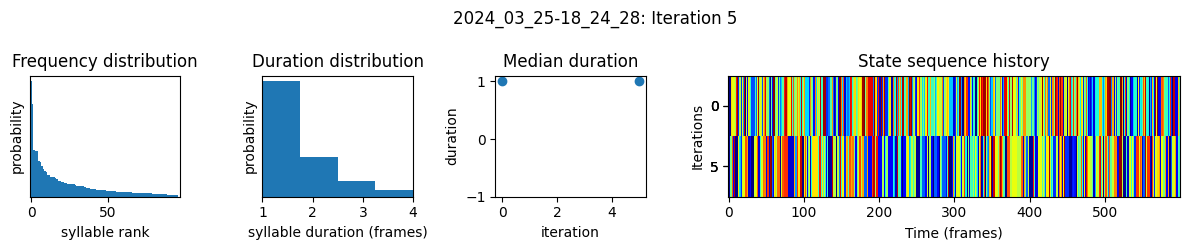

100%|█████████████████████████████████████| 6/6 [01:23<00:00, 13.86s/it]


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_26_00


 83%|██████████████████████████████▊      | 5/6 [00:23<00:04,  4.28s/it]

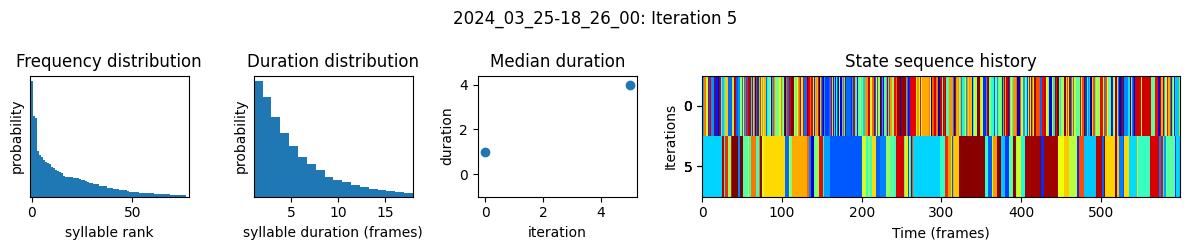

100%|█████████████████████████████████████| 6/6 [00:27<00:00,  4.64s/it]


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_26_34


 83%|██████████████████████████████▊      | 5/6 [00:21<00:04,  4.19s/it]

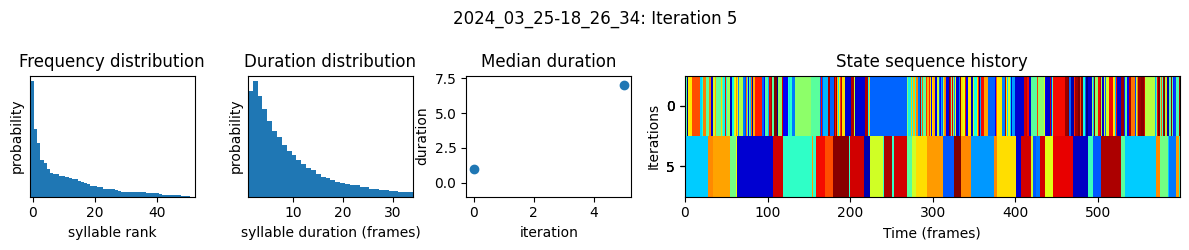

100%|█████████████████████████████████████| 6/6 [00:26<00:00,  4.39s/it]


In [40]:
moseq_train.PreFit.populate()

In [41]:
moseq_train.PreFit()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,pre_latent_dim Latent dimension to use for the model pre-fitting,pre_kappa Kappa value to use for the model pre-fitting,pre_num_iterations Number of Gibbs sampling iterations to run in the model pre-fitting,"model_name Name of the model as ""kpms_project_output_dir/model_name""",pre_fit_duration Time duration (seconds) of the model fitting computation
1,1,4,400,5,kpms_project_tutorial/2024_03_25-18_24_28,83.274
1,1,4,2000,5,kpms_project_tutorial/2024_03_25-18_26_00,27.9385
1,1,4,10000,5,kpms_project_tutorial/2024_03_25-18_26_34,26.4469


Now we can define a `FullFitTask` based on the selected `latent_dimension = 4`, the chosen `kappa = 10000`, and `num_iterations = 5` based on the previous exploration.

Again and for tutorial purposes, we will opt for a very low number of iterations (`num_iterations = 5`) to ensure the notebook runs quickly, taking just a few minutes.


In [42]:
moseq_train.FullFitTask.heading

# 
kpset_id             : int                          # Unique ID for each keypoint set
bodyparts_id         : int                          # Unique ID for a set of bodyparts for a particular keypoint set
full_latent_dim      : int                          # Latent dimension to use for the model full fitting
full_kappa           : int                          # Kappa value to use for the model full fitting
full_num_iterations  : int                          # Number of Gibbs sampling iterations to run in the model full fitting
---
full_fit_desc=""     : varchar(1000)                # User-defined description of the model full fitting task

In [44]:
# modify kappa to maintain the desired syllable time-scale
full_fit_key = {
    **pca_task_key,
    "full_latent_dim": 4,
    "full_kappa": 10000,
    "full_num_iterations": 5,
    "full_fit_desc": "Fitting task with kappa = 10000 ms",
}

moseq_train.FullFitTask.insert1(full_fit_key, skip_duplicates=True)

Let's add a second FullFitting task:


In [47]:
full_fitting_key_2 = {
    **pca_task_key,
    "full_latent_dim": 4,
    "full_kappa": 5000,
    "full_num_iterations": 5,
    "full_fit_desc": "Fitting task with kappa = 5000 ms",
}

moseq_train.FullFitTask.insert1(full_fitting_key_2, skip_duplicates=True)

In [48]:
moseq_train.FullFitTask()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,full_latent_dim Latent dimension to use for the model full fitting,full_kappa Kappa value to use for the model full fitting,full_num_iterations Number of Gibbs sampling iterations to run in the model full fitting,full_fit_desc User-defined description of the model full fitting task
1,1,4,5000,5,Fitting task with kappa = 5000 ms
1,1,4,10000,5,Fitting task with kappa = 10000 ms


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_28_00


 83%|██████████████████████████████▊      | 5/6 [01:54<00:21, 21.03s/it]

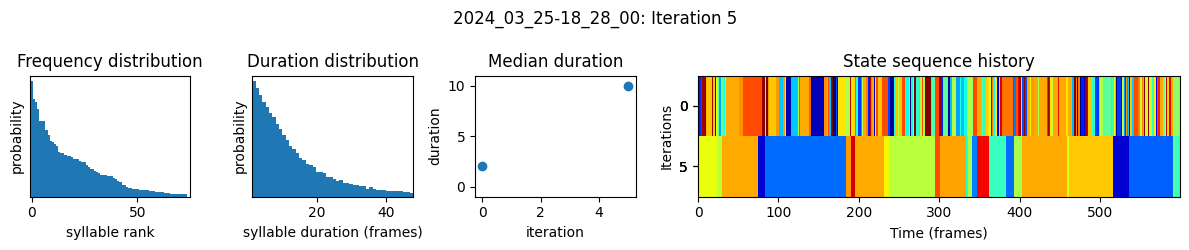

Reindexing: 100%|█████████████| 2/2 [00:00<00:00, 10.00model snapshot/s]


Outputs will be saved to /Users/milagros/Documents/datajoint-
elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_30_21


 83%|██████████████████████████████▊      | 5/6 [01:33<00:18, 18.84s/it]

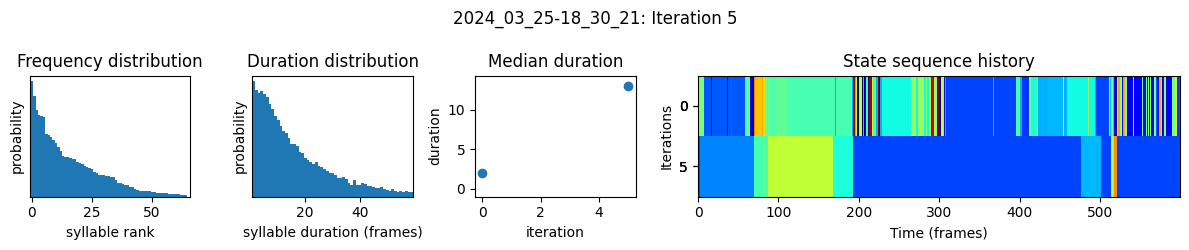

Reindexing: 100%|█████████████| 2/2 [00:00<00:00,  5.17model snapshot/s]


In [49]:
moseq_train.FullFit.populate()

In [50]:
moseq_train.FullFit()

kpset_id Unique ID for each keypoint set,bodyparts_id Unique ID for a set of bodyparts for a particular keypoint set,full_latent_dim Latent dimension to use for the model full fitting,full_kappa Kappa value to use for the model full fitting,full_num_iterations Number of Gibbs sampling iterations to run in the model full fitting,"model_name Name of the model as ""kpms_project_output_dir/model_name""",full_fit_duration Time duration (seconds) of the full fitting computation
1,1,4,5000,5,kpms_project_tutorial/2024_03_25-18_28_00,133.281
1,1,4,10000,5,kpms_project_tutorial/2024_03_25-18_30_21,113.123


### **Run the inference task and visualize the results**


The models, along with their relevant information, will be registered in the DataJoint pipeline as follows:


In [51]:
model_name, latent_dim, kappa = (moseq_train.FullFit & "full_kappa = 10000").fetch1(
    "model_name", "full_latent_dim", "full_kappa"
)
moseq_infer.Model.insert1(
    {
        "model_id": 1,
        "model_name": "model 1",
        "model_dir": model_name,
        "latent_dim": latent_dim,
        "kappa": kappa,
    },
    skip_duplicates=True,
)

In [52]:
model_name, latent_dim, kappa = (moseq_train.FullFit & "full_kappa = 5000").fetch1(
    "model_name", "full_latent_dim", "full_kappa"
)
moseq_infer.Model.insert1(
    {
        "model_id": 2,
        "model_name": "model 2",
        "model_dir": model_name,
        "latent_dim": latent_dim,
        "kappa": kappa,
    },
    skip_duplicates=True,
)

We can check the `Model` table to confirm that the two models have been registered:


In [53]:
moseq_infer.Model()

model_id Unique ID for each model,model_name User-friendly model name,model_dir Model directory relative to root data directory,latent_dim Latent dimension of the model,kappa Kappa value of the model,model_desc Optional. User-defined description of the model
1,model 1,kpms_project_tutorial/2024_03_25-18_30_21,4,10000,
2,model 2,kpms_project_tutorial/2024_03_25-18_28_00,4,5000,


#### Optional: Model comparison to select a model

The expected marginal likelihood (EML) score can be used to rank models. The model with the highest EML score can then be selected for further analysis.


100%|█████████████████████████████████████| 2/2 [00:05<00:00,  2.92s/it]

Best model: kpms_project_tutorial/2024_03_25-18_28_00



/Users/milagros/miniconda/envs/kpms_test/lib/python3.9/site-packages/keypoint_moseq/viz.py:2895: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



(<Figure size 400x350 with 1 Axes>, <Axes: ylabel='EML score'>)

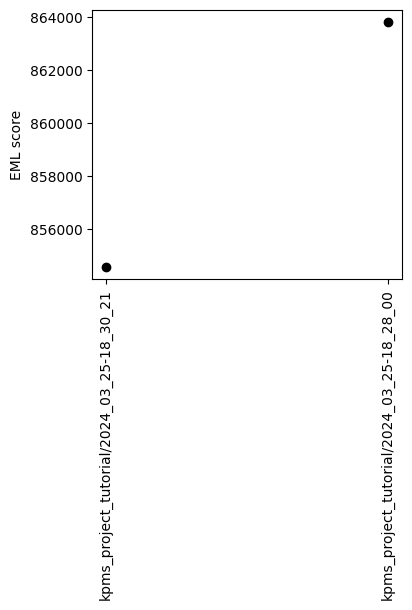

In [54]:
model_names = (moseq_train.FullFit).fetch("model_name")

checkpoint_paths = []
for model_name in model_names:
    checkpoint_paths.append(
        get_kpms_processed_data_dir() / Path(model_name) / "checkpoint.h5"
    )
checkpoint_paths

from keypoint_moseq import expected_marginal_likelihoods, plot_eml_scores

eml_scores, eml_std_errs = expected_marginal_likelihoods(
    checkpoint_paths=checkpoint_paths
)
best_model = model_names[np.argmax(eml_scores)]
print(f"Best model: {best_model}")

plot_eml_scores(eml_scores, eml_std_errs, model_names)

Thus, we choose the best ranked model for the inference task:


In [55]:
best_model_id = (moseq_infer.Model & "model_dir = '{}'".format(best_model)).fetch1(
    "model_id"
)
print(f"Best model id: {best_model_id}")

Best model id: 2


For tutorial purposes, we'll utilize the same video set (`videos_path`) employed for modeling training as the video set for inference. This will be incorporated into the `VideoRecording` table as well.


In [56]:
recording_key = {
    **key,
    "recording_id": 1,
}
moseq_infer.VideoRecording.insert1(
    {**recording_key, "device": "Camera1"}, skip_duplicates=True
)

In [57]:
for idx, video_name in enumerate(videos_path):
    moseq_infer.VideoRecording.File.insert1(
        dict(**recording_key, file_id=idx, file_path=video_name), skip_duplicates=True
    )

In [58]:
moseq_infer.VideoRecording * moseq_infer.VideoRecording.File

subject,session_datetime,recording_id Unique ID for each recording,file_id Unique ID for each file,device,"file_path Filepath of each video, relative to root data directory."
subject1,2024-03-15 14:04:22,1,0,Camera1,dlc_project/videos/21_12_10_def6a_3.top.ir.mp4
subject1,2024-03-15 14:04:22,1,1,Camera1,dlc_project/videos/22_04_26_cage4_1_1.top.ir.mp4
subject1,2024-03-15 14:04:22,1,2,Camera1,dlc_project/videos/21_12_10_def6a_1_1.top.ir.mp4
subject1,2024-03-15 14:04:22,1,3,Camera1,dlc_project/videos/22_27_04_cage4_mouse2_0.top.ir.mp4
subject1,2024-03-15 14:04:22,1,4,Camera1,dlc_project/videos/22_04_26_cage4_0.top.ir.mp4
subject1,2024-03-15 14:04:22,1,5,Camera1,dlc_project/videos/21_11_8_one_mouse.top.ir.Mp4
subject1,2024-03-15 14:04:22,1,6,Camera1,dlc_project/videos/21_12_2_def6b_2.top.ir.mp4
subject1,2024-03-15 14:04:22,1,7,Camera1,dlc_project/videos/21_12_10_def6b_3.top.ir.Mp4
subject1,2024-03-15 14:04:22,1,8,Camera1,dlc_project/videos/22_04_26_cage4_0_2.top.ir.mp4
subject1,2024-03-15 14:04:22,1,9,Camera1,dlc_project/videos/21_12_2_def6a_1.top.ir.mp4


The `InferenceTask` table serves the purpose of specifying an inference task:


In [59]:
moseq_infer.InferenceTask.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # Unique ID for each recording
model_id             : int                          # Unique ID for each model
---
pose_estimation_method : char(15)                     # Supported pose estimation method (deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap)
keypointset_dir      : varchar(1000)                # Keypointset directory for the specified VideoRecording
inference_output_dir="" : varchar(1000)                # Optional. Sub-directory where the results will be stored
inference_desc=""    : varchar(1000)                # Optional. User-defined description of the inference task
num_iterations=null  : int                          # Optional. Number of iterations to use for the model inference. If null, the default number internally is 50.

Defining and inserting a inference task requires:

1. Define the subject and session datetime
2. Define the video recording
3. Define the pose estimation method used for the video recording
4. Choose a model
5. Specify the output directory and any optional parameters


In [60]:
moseq_infer.InferenceTask.insert1(
    {
        **recording_key,
        "model_id": best_model_id,
        "pose_estimation_method": "deeplabcut",
        "keypointset_dir": "dlc_project/videos",
        "inference_output_dir": "inference_output",
        "inference_desc": "Inference task for the tutorial",
        "num_iterations": 5,  # Limited iterations for tutorial purposes.
    },
    skip_duplicates=True,
)

In [61]:
moseq_infer.InferenceTask()

subject,session_datetime,recording_id Unique ID for each recording,model_id Unique ID for each model,"pose_estimation_method Supported pose estimation method (deeplabcut, sleap, anipose, sleap-anipose, nwb, facemap)",keypointset_dir Keypointset directory for the specified VideoRecording,inference_output_dir Optional. Sub-directory where the results will be stored,inference_desc Optional. User-defined description of the inference task,"num_iterations Optional. Number of iterations to use for the model inference. If null, the default number internally is 50."
subject1,2024-03-15 14:04:22,1,2,deeplabcut,dlc_project/videos,inference_output,Inference task for the tutorial,5


Populating the `Inference` table will automatically extract learned states of the model (syllables, latent_state, centroid, and heading) and stored in the inference output directory together with visualizations and grid movies. The following function will take a few minutes.


Applying model: 100%|█████████████████████| 5/5 [01:24<00:00, 16.93s/it]


Saved results to /Users/milagros/Documents/datajoint-elements/element-
moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_28_00/inference_
output/results.h5


Saving to csv: 100%|████████████████████| 10/10 [00:01<00:00,  6.02it/s]


Saving trajectory plots to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_28_00/inference_output/trajectory_plots


Generating trajectory plots: 100%|██████| 46/46 [00:11<00:00,  4.01it/s]


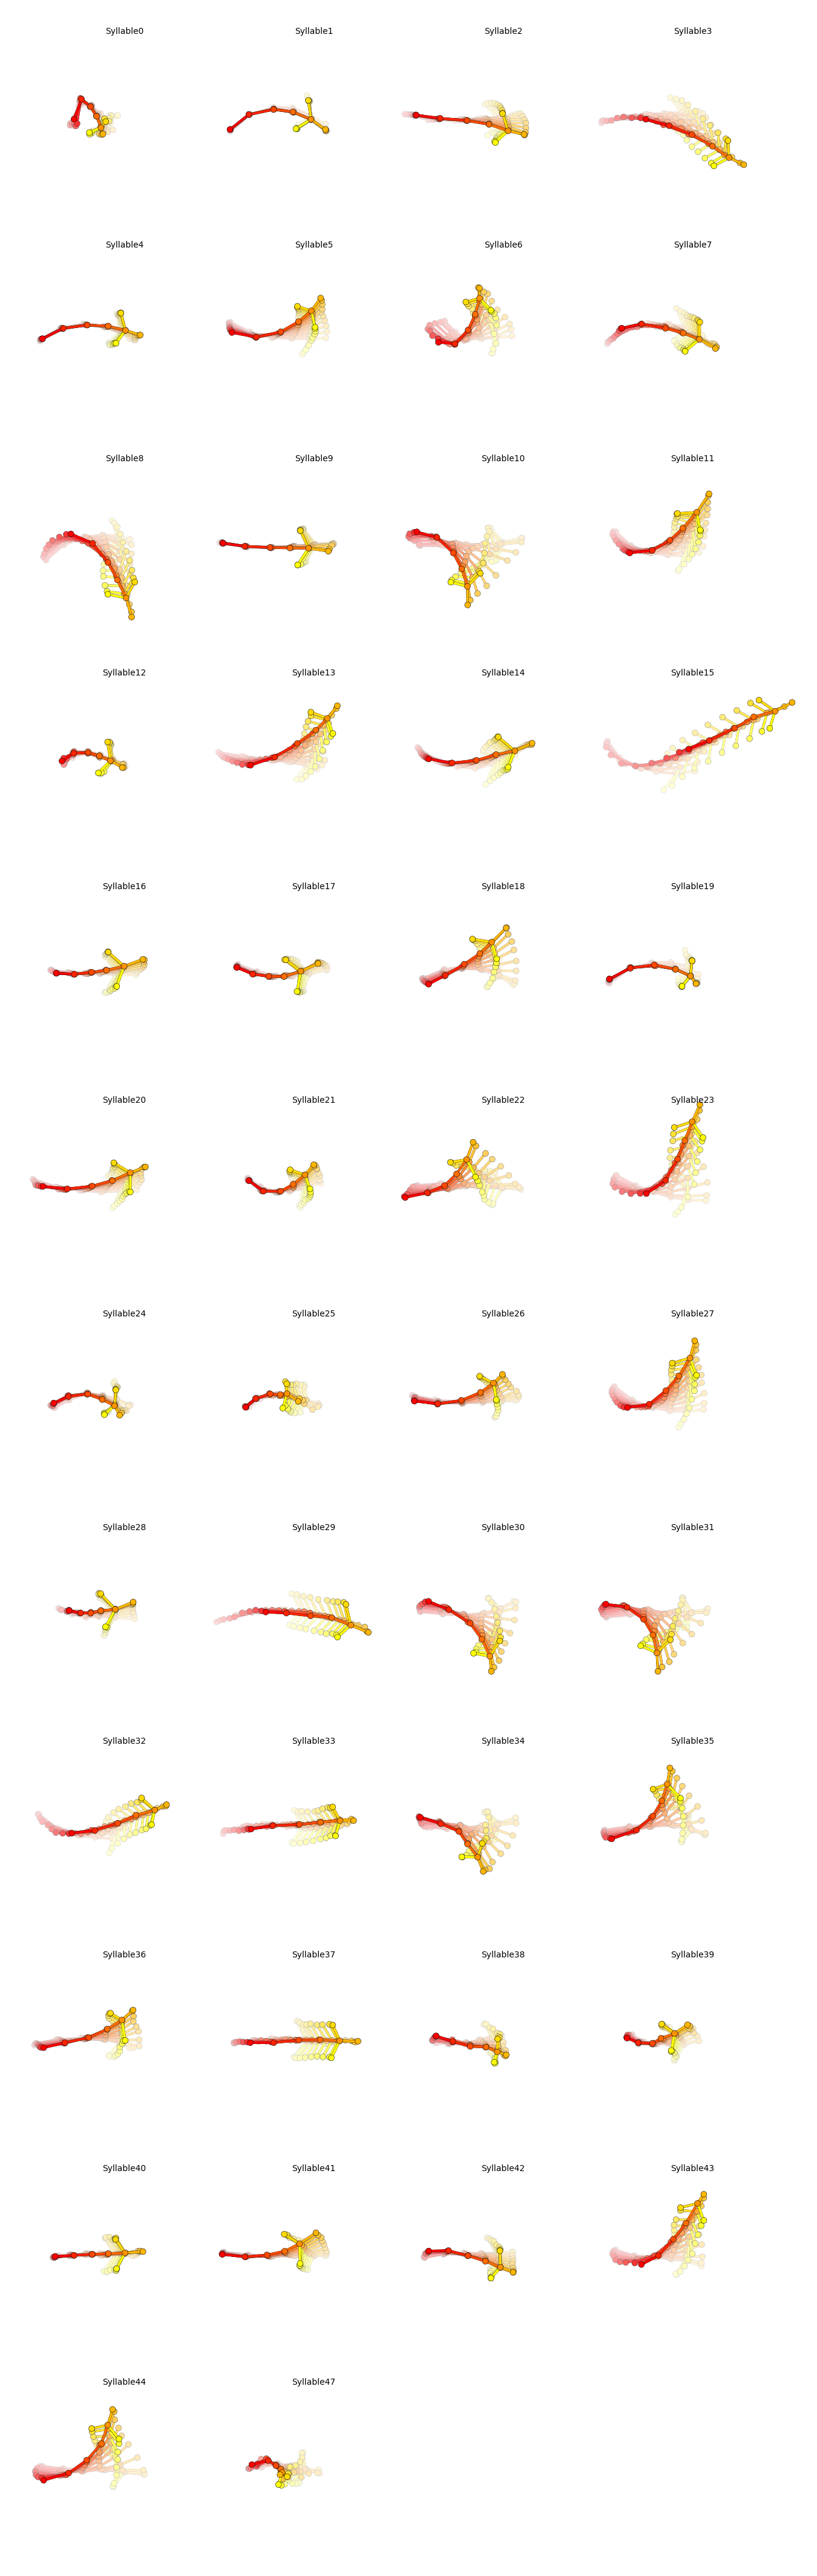

Writing grid movies to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_28_00/inference_output/grid_movies
Using window size of 144 pixels


Generating grid movies: 100%|███████████| 46/46 [01:40<00:00,  2.19s/it]


Saving dendrogram plot to /Users/milagros/Documents/datajoint-elements/element-moseq/data/outbox/kpms_project_tutorial/2024_03_25-18_28_00/inference_output/similarity_dendogram


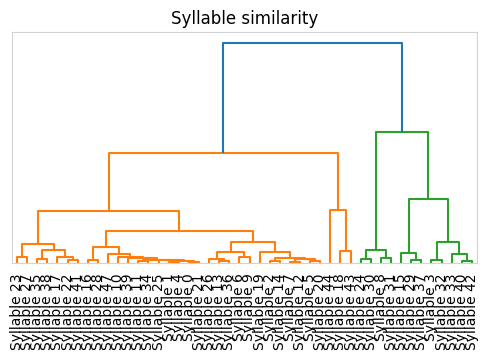

In [62]:
moseq_infer.Inference.populate()

In [63]:
moseq_infer.Inference()

subject,session_datetime,recording_id Unique ID for each recording,model_id Unique ID for each model,inference_duration Time duration (seconds) of the inference computation
subject1,2024-03-15 14:04:22,1,2,91.6917


The `MotionSequence` table contains the results for the inference (syllables, latent_state, centroid, and heading):


In [64]:
moseq_infer.Inference.MotionSequence()

subject,session_datetime,recording_id Unique ID for each recording,model_id Unique ID for each model,video_name Name of the video,syllable Syllable labels (z). The syllable label assigned to each frame (i.e. the state indexes assigned by the model),"latent_state Inferred low-dim pose state (x). Low-dimensional representation of the animal's pose in each frame. These are similar to PCA scores, are modified to reflect the pose dynamics and noise estimates inferred by the model","centroid Inferred centroid (v). The centroid of the animal in each frame, as estimated by the model","heading Inferred heading (h). The heading of the animal in each frame, as estimated by the model"
subject1,2024-03-15 14:04:22,1,2,21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2024-03-15 14:04:22,1,2,22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000,=BLOB=,=BLOB=,=BLOB=,=BLOB=


The `GridMoviesSampledInstances` table contains the sampled instances for the grid movies. The sampled instances is a dictionary mapping syllables to lists of instances shown in each grid movie (in row-major order).


In [65]:
moseq_infer.Inference.GridMoviesSampledInstances()

subject,session_datetime,recording_id Unique ID for each recording,model_id Unique ID for each model,syllable Syllable label,"instances List of instances shown in each in grid movie (in row-major order), where each instance is specified as a tuple with the video name, start frame and end frame"
subject1,2024-03-15 14:04:22,1,2,0,=BLOB=
subject1,2024-03-15 14:04:22,1,2,1,=BLOB=
subject1,2024-03-15 14:04:22,1,2,2,=BLOB=
subject1,2024-03-15 14:04:22,1,2,3,=BLOB=
subject1,2024-03-15 14:04:22,1,2,4,=BLOB=
subject1,2024-03-15 14:04:22,1,2,5,=BLOB=
subject1,2024-03-15 14:04:22,1,2,6,=BLOB=
subject1,2024-03-15 14:04:22,1,2,7,=BLOB=
subject1,2024-03-15 14:04:22,1,2,8,=BLOB=
subject1,2024-03-15 14:04:22,1,2,9,=BLOB=


In [66]:
instance_syllable_0 = (
    moseq_infer.Inference.GridMoviesSampledInstances & "syllable = 0"
).fetch1("instances")
instance_syllable_0

[('21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  70768,
  70773),
 ('21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  48436,
  48549),
 ('22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  22032,
  22174),
 ('22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  42401,
  42404),
 ('21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  56380,
  56410),
 ('21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  16921,
  16929),
 ('21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  53728,
  53735),
 ('21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  7369,
  7416),
 ('21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  5189,
  5195),
 ('22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000',
  32907,
  32932),
 ('21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug

The instance for syllable 0 is represented as a tuple containing the video name, start frame, and end frame. This format facilitates downstream analysis.


### Summary


Following this tutorial, we have:

- Covered the essential functionality of `element-moseq`
- Acquired the skills to load the keypoint data and insert metadata into the pipeline
- Learned how to fit a PCA, run the AR-HMM fitting and the Keypoint-SLDS fitting
- Executed and ingested results of the motion sequencing analysis with Keypoint-MoSeq
- Visualized and stored the results


#### Documentation and DataJoint tutorials


- Detailed [documentation on `element-moseq`](https://datajoint.com/docs/elements/element-moseq/0.1/)
- [General `DataJoint-Python` interactive tutorials](https://github.com/datajoint/datajoint-tutorials), covering fundamentals, such as table tiers, query operations, fetch operations, automated computations with the make function, and more.
- [Documentation for `DataJoint-Python`](https://datajoint.com/docs/core/datajoint-python/0.14/)
